---


<p align="center">
   <!---<img src="https://www.estudiaradistancia.com.ar/logos/original/logo-universidad-de-buenos-aires.webp" height=80 />--->
   <img src="https://confedi.org.ar/wp-content/uploads/2020/09/fiuba_logo.jpg" height="180"/>
</p>

---

<center><font size="+2">
  <h1> 75.26 / 95.19 Simulación </h1>

  <h2> Trabajo Práctico II </h2>

  <h3> Segundo Cuatrimestre - 2022 </h3>

</font></center>

---

<center><font size="+1">

  <h2>GRUPO 4</h2>

  <h2>INTEGRANTES</h2>

  <h4>Gestoso, Ramiro</h4>
  <h4>Brizuela Lopez, Mariano</h4>
  <h4>Markarian, Darío Hernan</h4>
  <h4>Ripetour, Diego</h4>

</font></center>


---

In [155]:
import random
import html5lib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Algoritmo de simulación de cadena de Markov

Dada matriz cuadrada que contenga en la posición i,j la probabilidad de cambiar de estado i a j y una cantidad n, se simula el cambio de estado de esta cadena n veces.

Se puede indicar un estado inicial (debe estar incluido en la matriz). Si no se lo indica, se toma uno al azar.

In [72]:
def simular_markov(matriz_estados, cantidad_simulaciones, estado_inicial=None):
    if estado_inicial == None:
        # elijo uno random de los n para iniciar
        v = random.randint(0, len(matriz_estados)-1)
    
    estados_recorridos = []
    
    # obtenemos el array de probabilidades del nodo v
    prob_estados = matriz_estados[v]
    
    for i in range(cantidad_simulaciones):
        estados_recorridos.append(v)
        ### print(f"Estado actual {v}")
        # simulamos una probabilidad que nos ayudará a elegir el próximo estado
        u = random.random()
        ### print(f"Probabilidad simulada {round(u,4)}\n")
        
        prob_acum = 0
        for j in range(len(matriz_estados)):
            prob_acum += prob_estados[j]
            if u <= prob_acum:
                # actualizamos el nodo y el array de probabilidades
                v = j
                prob_estados = matriz_estados[v]
                break
    return estados_recorridos

In [83]:
### mini prueba de simulacion
m = [
    [0.5,0.5],
    [0.4,0.6]
]
e = simular_markov(m, 10)
print(e)

[0, 0, 1, 1, 1, 0, 1, 0, 1, 1]


# Algoritmo para simular búsquedas con los resultados de Pagerank

# Algoritmo de Pagerank 

Es un algoritmo simple en el cual se crea la matriz de probabilidades según la cantidad de apariciones de una pagina en otra.
Si una pagina no contiene ninguna referencia, se toma la hipótesis de que el usuario elige una página al azar, todas con misma probabilidad, pero no vuelve a elegir la misma en la que estaba.

Una vez obtenida la matriz, se estima n tendiendo a infinito (ahora se usa un numero mucho menor) para calcular la cantidad de tiempo que un usuario está en cada página.

In [135]:
from bs4 import BeautifulSoup
import urllib.request

def matriz_probabilidades(paginas):
    ### matriz donde almacenamos la referencia de la pagina en la pos i
    referencias = [[] for i in paginas]
    
    ### recorremos las paginas y obtenemos las referencias a otras paginas
    for i in range(len(paginas)):
        html_page = urllib.request.urlopen("file:paginas/" + paginas[i])
        soup = BeautifulSoup(html_page, "html.parser")
        for link in soup.findAll('a'):
            referencias[i].append(link.get('href').lstrip('http://'))
    
    matriz = [ [] for i in range(len(paginas)) ]

    for i in range(len(referencias)):

        referidas = referencias[i]
        cantidad_referidas = len(referidas)

        if cantidad_referidas == 0:
            ### se le aplica la misma probabilidad a cada pagina (menos a ella misma)
            matriz[i] = [1/(cant_paginas-1) if j!=i else 0 for j in range(cant_paginas)]
        else:
            matriz[i] = [ referidas.count(pagina)/cantidad_referidas for pagina in paginas ]
            
    return matriz

def pagerank(paginas, power=100):
    '''
    Se puede elegir un numero arbitario para elevar la matriz con el parametro power.
    Cuanto mas alto, mas precision. Para nuestro ejemplo con 100 alcanza y sobra.
    '''
    matriz_paginas = np.array(matriz_probabilidades(paginas))
    return np.linalg.matrix_power(matriz_paginas, power)[0]


### Generamos la matriz que representa la probabilidad de navegar por cada pagina a partir de la anterior (Cadena de Markov)

In [143]:
pags = [
    'angelinajolie.html',
    'bradpitt.html',
    'jenniferaniston.html',
    'jonvoight.html',
    'martinscorcese.html',
    'robertdeniro.html'
]
matriz = matriz_probabilidades(paginas)

Visualizamos la matriz de probabilidades

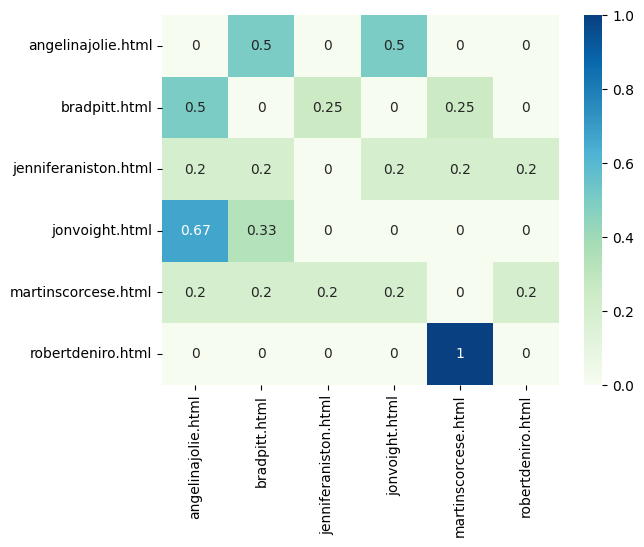

In [179]:
sns.heatmap(matriz, annot=True, cmap='GnBu', xticklabels=pags, yticklabels=pags)
plt.show()

Realizamos una simulación de un usuario navegando por las paginas y graficamos la probabilidad de visitas de cada una

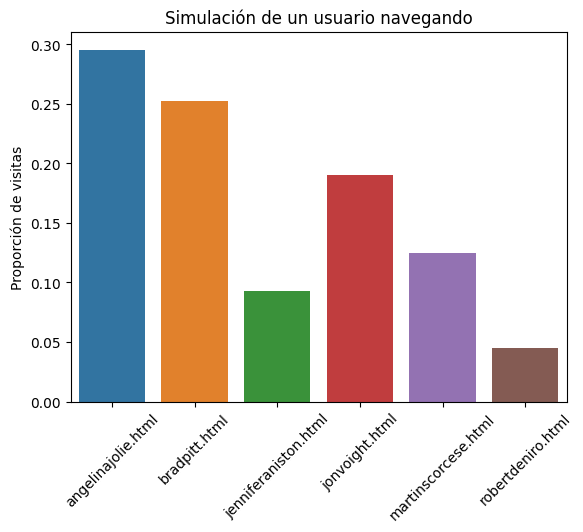

In [192]:
n = 10_000
estados = simular_markov(matriz, n)
unique, counts = np.unique(estados, return_counts=True)
sns.barplot(x=pags, y=(counts/n))
plt.title('Simulación de un usuario navegando')
plt.xticks(rotation = 45)
plt.ylabel('Proporción de visitas')
plt.show()

### Ahora calculamos y graficamos el Pagerank de cada pagina

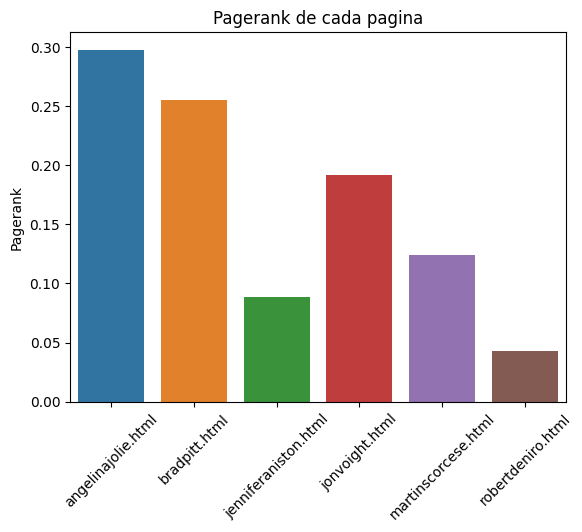

In [190]:
sns.barplot(x=pags, y=pagerank(pags))
plt.title('Pagerank de cada pagina')
plt.xticks(rotation = 45)
plt.ylabel('Pagerank')
plt.show()

Podemos observar que ambos graficos coinciden. Si bien representan lo mismo, los resultados se obtuvieron por caminos diferentes.

En el primer caso, se realizó una simulación de un usuario navegando por las páginas a través de los links referidos y se obtuvo la proporción de veces que el usuario visitó cada página.

En el segundo caso, se obtuvo un resultado más teórico (si bien no se calculó el comportamiento asintótico, se aproximó) que representa la probabilidad de terminar en una página. Esta probabilidad representará el Pagerank de la pagina y representará la importancia de la misma

## Simulación de busquedas